## Topic Modeling Tweets

Using tweets with the hashtag #micropoetry to better understand the popularity of poetic topics in the post internet age.

We'll be doing <a href="https://en.wikipedia.org/wiki/Topic_model">Topic Modeling</a> to understand what the tweets are about.


"%matplotlib inline" makes sure all our graphs appear inside the window.

Import stuff: os and glob for files, numpy and sklearn for math, matplotlib for plotting, operator for sorting, pandas for CSV reading, and re for tweet cleaning.

In [1]:
%matplotlib inline
import os
import glob
import numpy as np
import sklearn.feature_extraction.text as text
from sklearn import decomposition
import matplotlib.pyplot as plt
import operator
import pandas as pd
import re

glob.glob will find all the files in the "Individual Tweets" directory and put them in a list for us, and the sorted function will sort that list (numerically).

In [2]:
filenames = sorted(glob.glob('twitter/Individual Tweets/*'))

Let's check to see how many individual tweets (TXT files) we have:

For that we use the len function to check the length of the filenames list.

In [3]:
print(len(filenames))

7668


Let's check the names of the first 5 tweets.

":5" just means from beginning to 5.

In [4]:
print(filenames[:5])

['twitter/Individual Tweets/00001.txt', 'twitter/Individual Tweets/00002.txt', 'twitter/Individual Tweets/00003.txt', 'twitter/Individual Tweets/00004.txt', 'twitter/Individual Tweets/00005.txt']


Convert the collection of text documents to a matrix of token counts:

http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [5]:
vectorizer = text.CountVectorizer(input='filename', stop_words='english', min_df=20)

Documentation on fit_transform and get_feature_names:

http://scikit-learn.org/stable/modules/feature_extraction.html

In [6]:
dtm = vectorizer.fit_transform(filenames).toarray()

In [7]:
vocab = np.array(vectorizer.get_feature_names())

Set how many topics we want.

In [8]:
num_topics = 10

Set how many words we want in each topic.

In [9]:
num_top_words = 20

Non-Negative Matrix Factorization (NMF)

Find two non-negative matrices (W, H) whose product approximates the non-negative matrix X.

http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

In [10]:
clf = decomposition.NMF(n_components=num_topics, random_state=1)

In [11]:
doctopic = clf.fit_transform(dtm)

Make an empty list.

In [12]:
topic_words = []

Fill that list with the topic words. Here, [::-1] is just a way to reverse the array.

In [13]:
for topic in clf.components_:
    word_idx = np.argsort(topic)[::-1][0:num_top_words]
    topic_words.append([vocab[i] for i in word_idx])

In [14]:
doctopic = doctopic / np.sum(doctopic, axis=1, keepdims=True)

Make an empty list.

In [15]:
tweet_names = []

Fill the list with file names.

In [16]:
for fn in filenames:
    basename = os.path.basename(fn)
    name, ext = os.path.splitext(basename)
    tweet_names.append(name)

Make the list an array.

In [17]:
tweet_names = np.asarray(tweet_names)

Copy the doctopic.

In [18]:
doctopic_orig = doctopic.copy()

In [19]:
num_groups = len(set(tweet_names))

Make a grouped doctopic.

In [20]:
doctopic_grouped = np.zeros((num_groups, num_topics))

In [21]:
for i, name in enumerate(sorted(set(tweet_names))):
    doctopic_grouped[i, :] = np.mean(doctopic[tweet_names == name, :], axis=0)

Set the old doctopic to be the grouped one.

In [22]:
doctopic = doctopic_grouped

In [23]:
tweets = sorted(set(tweet_names))

Create a dictionary of tweets and their top topics.

In [24]:
d = {}
for i in range(len(doctopic)):
    top_topics = np.argsort(doctopic[i,:])[::-1][0:1]
    top_topics_str = ' '.join(str(t) for t in top_topics)
    d[tweets[i]] = top_topics_str
    #print("{}: {}".format(tweets[i], top_topics_str))
s = sorted(d.items(), key=operator.itemgetter(0))

Open up a comma-separated values sheet.

In [25]:
micro_poems_csv = pd.read_csv('micro_poetry.csv', header=1, encoding='latin1')

In [26]:
len(micro_poems_csv)

21632

Make a dictionary out of it.

In [27]:
micro_poems_dict = micro_poems_csv.to_dict()

Make a list of tweets.

In [28]:
l = [value for key, value in micro_poems_dict["Tweet Text"].items()]

Clean up the tweets. Here, we remove "RT" for "retweet," remove links, and make the tweet lowercase, and add it into the list "l2."

In [29]:
l2 = []
for tweet in l:
    tweet = tweet.replace("RT", "")
    tweet = ' '.join(re.sub("(\#[A-Za-z0-9_]+)|(@[A-Za-z0-9_]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", tweet).split())
    tweet = ' '.join(re.sub("( tco[A-Za-z0-9]+)", "", tweet).split())
    tweet = tweet.replace("https", "")
    tweet = tweet.replace("http", "")
    tweet = tweet.lower()
    l2.append(tweet)

Make a dictionary containing the tweets as keys and the number of occurrences as values

In [30]:
d = {}
for tweet in l2:
    if tweet not in d:
        d[tweet] = 1
    else:
        d[tweet] += 1

Make a list of file names.

In [31]:
l3 = [tup[0] for tup in s]

Make a list of favorites per tweet.

In [32]:
l4 = [value for key, value in micro_poems_dict["Favorites"].items()]

Make a list of top topics per tweet.

In [33]:
l5 = []
for tup in s:
    l5.append(tup[1])

Make a list of retweets per tweet.

In [34]:
l6 = [value for key, value in micro_poems_dict["Retweets"].items()]

Make a list of tuples, containing the top topic in a tweet and the number of favorites in that tweet.

In [35]:
s2 = list(zip(l5, l4))

Make a list of tuples, each containing the top topic in a tweet and the number of retweets in that tweet.

In [36]:
s3 = list(zip(l5, l6))

Plot the favorites per topic.

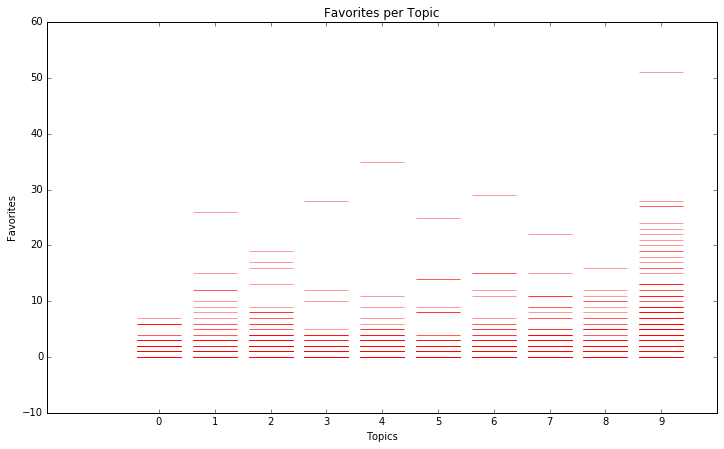

In [37]:
plt.figure(figsize=(12, 7))
plt.scatter(*zip(*s2), color='r', s=2000, marker='_', alpha=.4)
plt.xticks(np.arange(10))
plt.title('Favorites per Topic')
plt.xlabel('Topics')
plt.ylabel('Favorites')
plt.show()

Plot the retweets per topic.

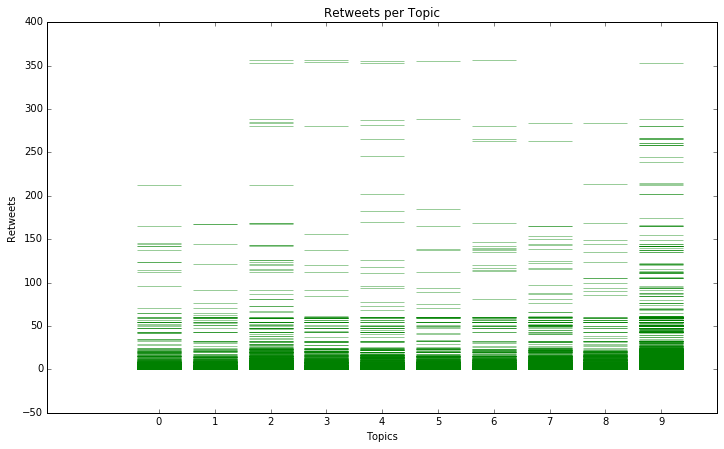

In [38]:
plt.figure(figsize=(12, 7))
plt.scatter(*zip(*s3), color='g', s=2000, marker='_', alpha=.4)
plt.xticks(np.arange(10))
plt.title('Retweets per Topic')
plt.xlabel('Topics')
plt.ylabel('Retweets')
plt.show()

Show the content of the topics up to the 15th word.

In [39]:
for t in range(len(topic_words)):
    print("Topic {}: {}".format(t, ' '.join(topic_words[t][:15])))

Topic 0: love true lost fall touch want old live lust god lips feel matter theres poetry
Topic 1: like feel god kiss days sky wind look wild warm thats away soul honey lips
Topic 2: know im dont want youre need going say write feel fast verse think good mind
Topic 3: just write verse bit little way wait ill light think away thats let fast smile
Topic 4: words poetry soul come say silence said make poems way voice muse sweet ive let
Topic 5: heart soul mind let apart loves inside amp broken smile head song skin beat run
Topic 6: time come away way mind day little place tea gone hearts maybe rain distant let
Topic 7: eyes soul smile lips dreams kiss world look closed light sleep blue mind god deep
Topic 8: life say things sit death reflect way old think right does man living hope change
Topic 9: night day sky moon light sun winter rain morning wind stars cold clouds leaves black


What do you notice about the differences between the graphs? What conclusions can you draw from those differences in light of the topics?

Thanks for reading! 

Happy Coding!